# Quick Implementation of multiple ML/DL Survival analysis methods with PySurvival

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.model_selection import ShuffleSplit, GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd 
import numpy as np
import snowflake.connector
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import serialization

#pip install snowflake-connector-python --user

from pycox.utils import kaplan_meier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
import torch
import torchtuples as tt
from pycox.datasets import metabric
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.models import CoxPH, LogisticHazard

/home/csouvigny/.conda/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_data(query):
    with open("/home/shared/csouvign/rsa_key.p8", "rb") as key:
        p_key= serialization.load_pem_private_key(
            key.read(),
            password='2B@XS5E&!5%UCab'.encode(),
        )

    pkb = p_key.private_bytes(
        encoding=serialization.Encoding.DER,
        format=serialization.PrivateFormat.PKCS8,
        encryption_algorithm=serialization.NoEncryption())

    ctx = snowflake.connector.connect(
        user='camille.souvigny@ubisoft.com',
        account='ubisoft.us-east-1',
        private_key=pkb,
        warehouse='EMEA_ANALYTICS_COMMON',
        database='SANDBOX',
        schema='EMEA_ANALYTICS_CRM_PRIVATE',
        role='SNK_F_EMEAANALYTICS_CRM_SB_DEV',
        proxy_host='http://proxy.ubisoft.org',
        proxy_port='3128'
        )

    try:
        cur = ctx.cursor().execute(query)
        df = cur.fetch_pandas_all()
    except:
        df = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])
    finally:
        cur.close()
        print("successfull closed connection")
    ctx.close()
    
    return df


def data_cleaning(df):
    
    df[list(df.drop(['USER_KEY','CLUSTER_2021','CLUSTER_2022','P2_LAST_OWNED'], axis=1).select_dtypes(include = ['object']).columns)] = df[list(df.drop(['USER_KEY','CLUSTER_2021','CLUSTER_2022','P2_LAST_OWNED'], axis=1).select_dtypes(include=['object']).columns)].astype(float)
    df.SENIORITY_WHEN_CONV_TO_LAST_OWNED[df.SENIORITY_WHEN_CONV_TO_LAST_OWNED.isna()] = df.SENIORITY_LAST_OWNED[df.SENIORITY_WHEN_CONV_TO_LAST_OWNED.isna()]

    mean_playtime_one_pd = df[df.LAST_OWNED_PLAYTIME>=0][df.NB_PD_LAST_OWNED==1].LAST_OWNED_PLAYTIME.mean()
    df.loc[df[df.LAST_OWNED_PLAYTIME.isna()].index,'LAST_OWNED_PLAYTIME'] = mean_playtime_one_pd

    fill_zero={  
            'LAST_OWNED_PLAYTIME_10D'        : 0
           , 'PLAYTIME_LAST_OWNED_10D_RATIO' : 0
           , 'MIN_P2_PLAYTIME_10D'           : 0
           , 'MAX_P2_PLAYTIME_10D'           : 0
           , 'AVG_P2_PLAYTIME_10D'           : 0
           , 'SUM_P2_PLAYTIME_10D'           : 0
           , 'MIN_AC_PLAYTIME_10D'           : 0
           , 'MAX_AC_PLAYTIME_10D'           : 0
           , 'AVG_AC_PLAYTIME_10D'           : 0
           , 'SUM_AC_PLAYTIME_10D'           : 0
           , 'MIN_PLAYTIME_10D_RATIO'        : 0 
           , 'AVG_PLAYTIME_10D_RATIO'        : 0
           , 'MAX_PLAYTIME_10D_RATIO'        : 0 
           , 'MIN_P2_PLAYTIME'               : 0                   
           , 'MAX_P2_PLAYTIME'               : 0                   
           , 'AVG_P2_PLAYTIME'               : 0                   
           , 'SUM_P2_PLAYTIME'               : 0
           , 'MIN_AC_PLAYTIME'               : 0
           , 'MAX_AC_PLAYTIME'               : 0
           , 'AVG_AC_PLAYTIME'               : 0
           , 'SUM_AC_PLAYTIME'               : 0
           , 'AC_DLC'                        : 0
           , 'AC_P2_DLC'                     : 0 
           , 'AC_CURRENCY'                   : 0
           , 'AC_P2_CURRENCY'                : 0 
           , 'AC_SEASONPASS'                 : 0 
           , 'AC_P2_SEASONPASS'              : 0 
           , 'NB_ACTIVATION_PASS'            : 0
           , 'PD_FW'                         : 0
           , 'PD_AC_FW'                      : 0 
           , 'PD_P2_FW'                      : 0 
           , 'PD_ACV_FW'                     : 0
           , 'PD_AC_OB'                      : 0 
           , 'PD_P2_OB'                      : 0
           , 'PD_TRIAL'                      : 0
    }
    df = df.fillna(value=fill_zero)
    df = df.dropna(subset=['RECENCY_LAST_OWNED',
                           'SENIORITY_LAST_OWNED',
                           'NB_AC', 'PLAYED_ORIGINS',
                           'ESTIM_BG','ESTIM_NET_BG',
                           'PL_ACQUI', 'PL_NET_ACQUI',
                            'P2_LAST_OWNED' ])
    
    df["P2_LAST_OWNED_ASSASSIN'S CREED ODYSSEY"] =  df.P2_LAST_OWNED.apply(lambda x: 1 if x == "ASSASSIN'S CREED ODYSSEY" else 0)
    df = df.drop(["P2_LAST_OWNED"], axis=1)
    return df

def pb_at_conv(x):
    #return  nb_covariate -1 + int(x.TEND) - 30
    try :
        return x[int(x.CONVERSION_DAYS_ACV)]
    except :
        return np.nan
    
def pb_at_conv_moins1M(x):
    try :
        return x[int(x.CONVERSION_DAYS_ACV) - 30]
    except :
        return np.nan
    
def pb_at_conv_plus1M(x):
    try:
        return x[int(x.CONVERSION_DAYS_ACV) + 30 ]
    except :
        return np.nan

def pb_at_conv_plus10D(x):
    try:
        return x[int(x.CONVERSION_DAYS_ACV) + 10 ]
    except :
        return np.nan
    
def pred_AC_survival(pred_set, test_set):
    pred_set['pb_conv']=pred_set.apply(pb_at_conv, axis=1)
    pred_set['pb_conv_moins1M']=pred_set.apply(pb_at_conv_moins1M, axis=1)
    pred_set['pb_conv_plus1M']=pred_set.apply(pb_at_conv_plus1M , axis=1)
    pred_set['pb_conv_plus10D']=pred_set.apply(pb_at_conv_plus10D, axis=1)
    return pred_set

In [3]:
from datetime import datetime
start_time = datetime.now()

AC = get_data (''' select * from CS_AC_P2_PLAYERS_CONVERSION_MODEL_ON_ACV sample(0.1); ''')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

AC = data_cleaning(AC)
print('missing values : ', np.any(np.isnan(AC.drop(['USER_KEY','CLUSTER_2021','CLUSTER_2022'], axis=1))))
print('all finite values : ', np.all(np.isfinite(AC.drop(['USER_KEY','CLUSTER_2021','CLUSTER_2022'], axis=1))))

successfull closed connection
Duration: 0:00:06.922622
missing values :  False
all finite values :  True


/tmp/ipykernel_7421/1192090311.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.SENIORITY_WHEN_CONV_TO_LAST_OWNED[df.SENIORITY_WHEN_CONV_TO_LAST_OWNED.isna()] = df.SENIORITY_LAST_OWNED[df.SENIORITY_WHEN_CONV_TO_LAST_OWNED.isna()]
/tmp/ipykernel_7421/1192090311.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mean_playtime_one_pd = df[df.LAST_OWNED_PLAYTIME>=0][df.NB_PD_LAST_OWNED==1].LAST_OWNED_PLAYTIME.mean()


In [7]:
test_last_month = get_data('''
    with t as (select  AC.*
           , TO_DATE((TO_CHAR(PR.FIRST_PLAYED_DATE_KEY)),'YYYYMMDD') - TO_DATE((TO_CHAR(20201110)),'YYYYMMDD') +1 as acv_acqui_delay_valid

    from SANDBOX.EMEA_ANALYTICS_CRM_PRIVATE.CS_AC_P2_PLAYERS_CONVERSION_MODEL_ON_ACV AC
        inner join UBICENTRAL.PLAY_SHARED.VW_AGG_FT_USER_PRODUCT PR
            on PR.USER_KEY=AC.USER_KEY
        inner join UBICENTRAL.PLAY_SHARED.VW_DIM_GENOME_DENORMALIZED_ACTIVE G 
            on G.GENOME_KEY=PR.GENOME_KEY
    where CONVERTED_VALHALLA=0 
        and  INSTALLMENT_DESCRIPTION like '%ASSASSIN%VALHALLA%' 
        and PR.CALCULATED_GAME_RELEASE_KEY=5
        and FIRST_PLAYED_DATE_KEY > 20220701
        and number_played_days > 0
        QUALIFY RANK() OVER (PARTITION BY AC.USER_KEY ORDER BY PR.FIRST_PLAYED_DATE_KEY ASC)=1 
        )
        
 select *
 from t sample(20);
''')

test_last_month = data_cleaning(test_last_month)

successfull closed connection


/tmp/ipykernel_274/1192090311.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.SENIORITY_WHEN_CONV_TO_LAST_OWNED[df.SENIORITY_WHEN_CONV_TO_LAST_OWNED.isna()] = df.SENIORITY_LAST_OWNED[df.SENIORITY_WHEN_CONV_TO_LAST_OWNED.isna()]
/tmp/ipykernel_274/1192090311.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mean_playtime_one_pd = df[df.LAST_OWNED_PLAYTIME>=0][df.NB_PD_LAST_OWNED==1].LAST_OWNED_PLAYTIME.mean()


In [4]:
df_train = AC.drop(['USER_KEY','CLUSTER_2021','CLUSTER_2022'], axis=1)
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

Pysurvival : Fast implementation of surival models using API with C++ and based on Pytorch and SciPy

    Can be a first package to use since its easy and quick to use (data processing is done internally)
    Can fit ML and DL models : 
        coxPH, DeepSurv, Multi-Task Logistic Regression (linear & Non linear), Parametric models, Forest, SVM
    Performance metric used : C-index (concordance) and Brier Score
    
    Source : https://square.github.io/pysurvival/

In [5]:
#from pysurvival.models.simulations import SimulationModel
from pysurvival.models.semi_parametric import NonLinearCoxPHModel, CoxPHModel
from pysurvival.models.multi_task import LinearMultiTaskModel, NeuralMultiTaskModel
from pysurvival.models.parametric import ExponentialModel, GompertzModel, WeibullModel , LogLogisticModel , LogNormalModel
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel, ExtraSurvivalTreesModel, RandomSurvivalForestModel
from pysurvival.models.svm import LinearSVMModel, KernelSVMModel
from pysurvival.utils.metrics import concordance_index, brier_score
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.display import display_baseline_simulations
from scipy.stats import pearsonr

/home/csouvigny/.conda/envs/pytorch/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
X_train, X_test = df_train.drop(['CONVERSION_DAYS_ACV','CONVERTED_VALHALLA'],axis=1), df_test.drop(['CONVERSION_DAYS_ACV','CONVERTED_VALHALLA'],axis=1)
T_train, T_test = df_train['CONVERSION_DAYS_ACV'].values, df_test['CONVERSION_DAYS_ACV'].values
E_train, E_test = df_train['CONVERTED_VALHALLA'].values, df_test['CONVERTED_VALHALLA'].values

X_to_predict = test_last_month.drop(['CONVERSION_DAYS_ACV','CONVERTED_VALHALLA', 'USER_KEY', 'CLUSTER_2021', 'CLUSTER_2022'],axis=1)
T_to_predict = test_last_month['CONVERSION_DAYS_ACV'].values
E_to_predict = test_last_month['CONVERTED_VALHALLA'].values

In [70]:
structure_nl_coxph = [ {'activation': 'BentIdentity', 'num_units': 32},    ]
structure_n_mtlr = [ {'activation': 'ReLU', 'num_units': 535},  ]

# Semi and Non parametric ML/DL models
CoxPH = CoxPHModel()
NL_CoxPH = NonLinearCoxPHModel(structure=structure_nl_coxph)
L_MTLR = LinearMultiTaskModel(bins=50)
NN_MTLR = NeuralMultiTaskModel(structure=structure_n_mtlr, bins=150)

# Parametric models
exp = ExponentialModel()
gp = GompertzModel()
wb = WeibullModel() 
llog = LogLogisticModel() 
nlog = LogNormalModel()

# Trees
csf = ConditionalSurvivalForestModel(num_trees=20)
xst = ExtraSurvivalTreesModel(num_trees=50)
rsf = RandomSurvivalForestModel(num_trees=50)

# Support Vector Machine
svm_linear = LinearSVMModel()

models = { 
    'Linear CoxPH' : CoxPH ,
    'Non Linear coxph' : NL_CoxPH ,
    'Linear multi task model' : L_MTLR,
    'NN multi task model' : NN_MTLR,
    'Param Exp' : exp,
    'Param Gompertz' : gp,
    'Param Weibull' : wb,
    'Param Logistic' : llog,
    'Param Normal' : nlog,
    'Param Conditional Forest' : csf,
    'Param Extra Forest' : xst,
    'Param Random Forest' : rsf,
   # 'svm_linear' : svm_linear
         }

In [ ]:
# Each model must be tuned before fiting 
def function() :
try :
    CoxPH.fit(X_train, T_train, E_train, lr=0.5, l2_reg=1e-2, init_method='zeros')
except :
    print("CoxPH error fitting")
    
try :
    NL_CoxPH.fit(X_train, T_train, E_train, lr=1e-3, init_method='xav_uniform')
except :
    print("NL COxPH error fitting")
try :
    L_MTLR.fit(X_train, T_train, E_train, lr=1e-3, init_method='orthogonal')
except :
    print("L_MTLR error fitting")
    
try :
    NN_MTLR.fit(X_train, T_train, E_train, lr=1e-3, num_epochs = 500,init_method='orthogonal', optimizer = 'rprop')
except :
    print("NN MTLR error fitting")
    
for parametric_model in [exp, gp, wb, llog, nlog]:
    try:
        parametric_model.fit(X_train, T_train, E_train, lr=1e-2, init_method='zeros', optimizer ='adam', l2_reg = 1e-3, num_epochs=2000)
    except :
        print("param model error fitting")

    
try :
    csf.fit(X_train, T_train, E_train, max_features="sqrt", max_depth=15, min_node_size=20, alpha = 0.05, minprop=0.1)
except :
    print("CSF error fitting")
try :
    xst.fit(X_train, T_train, E_train, max_features="sqrt", max_depth=5, min_node_size=20, num_random_splits = 100)
except :
    print("XST error fitting")
try :
    rsf.fit(X_train, T_train, E_train, max_features="sqrt", max_depth=5, min_node_size=20)
except :
    print("RSF error fitting")
try :
    svm_linear.fit(X_train, T_train, E_train, init_method='he_uniform', with_bias = True, lr = 0.5,  tol = 1e-3,  l2_reg = 1e-3)
except :
    print("SVM error fitting")

In [7]:
csf = ConditionalSurvivalForestModel(num_trees=20)
csf.fit(X_train, T_train, E_train, max_features="sqrt", max_depth=15, min_node_size=20, alpha = 0.05, minprop=0.1)

ConditionalSurvivalForestModel

In [10]:
len(csf.variable_importance)

118

### Accuracy metrics

In [ ]:
def create_dict_metric(list_of_models):
    accuracy_metrics={}
    for model_name, model in models.items() :
        try :
            it_brier = integrated_brier_score(model, X_test, T_test, E_test, t_max=max(csf.times), figure_size=(2, 1))
        except:
            it_brier = np.nan
        try :
            c_score = concordance_index(model, X_test, T_test, E_test)
        except:
            c_score = np.nan
        try :
            brier = brier_score(model, X_test, T_test, E_test, t_max=max(model.times))
        except:
            brier = np.zeros(round(max(model.times)))

        accuracy_metrics[model_name]=(c_score, round(it_brier,3), brier[1])
    return accuracy_metrics

accuracy_metrics = create_dict_metric(models)

In [73]:
for model, acc in accuracy_metrics.items() :
    print(model, 'concordance : ', accuracy_metrics[model][0], 'integrated brier : ', accuracy_metrics[model][1])

Linear CoxPH concordance :  0.8889241660384047 integrated brier :  0.313
Non Linear coxph concordance :  0.9749000419772795 integrated brier :  0.008
Linear multi task model concordance :  0.6299413575607907 integrated brier :  0.26
NN multi task model concordance :  0.9595346210757082 integrated brier :  0.014
Param Exp concordance :  0.5802438514663005 integrated brier :  0.547
Param Gompertz concordance :  0.7211289433043244 integrated brier :  4.974895469680438e+53
Param Weibull concordance :  0.5 integrated brier :  0.509
Param Logistic concordance :  0.5 integrated brier :  0.058
Param Normal concordance :  nan integrated brier :  0.739
Param Conditional Forest concordance :  0.9275090706254255 integrated brier :  0.044
Param Extra Forest concordance :  0.8753387374839142 integrated brier :  0.109
Param Random Forest concordance :  0.9194656609684955 integrated brier :  0.062


In [74]:
print('best integrated brier score : ', min(accuracy_metrics.items(), key=lambda x: x[1][1])[0], min(accuracy_metrics.items(), key=lambda x: x[1][1])[1][1])
print('best c-score : ', max(accuracy_metrics.items(), key=lambda x: x[1][0])[0], max(accuracy_metrics.items(), key=lambda x: x[1][0])[1][0])

best integrated brier score :  Non Linear coxph 0.008
best c-score :  Non Linear coxph 0.9749000419772795


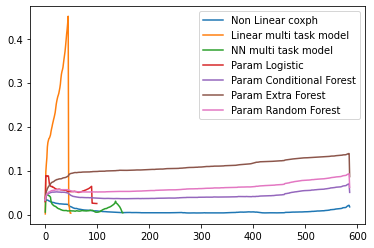

In [75]:
# Only plot models with integrated brier score lower than 0.3
for model_name, acc in accuracy_metrics.items():
    if acc[1]<0.3 :
        plt.plot(acc[2], label=model_name)
plt.legend()
plt.show()

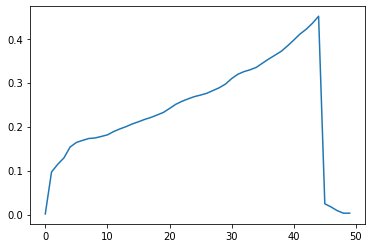

In [79]:
plt.plot(accuracy_metrics['Linear multi task model'][2])

In [73]:
structure_nl_coxph = [ {'activation': 'BentIdentity', 'num_units': 32}, {'activation': 'Tanh', 'num_units': 32} ]
NL_CoxPH = NonLinearCoxPHModel(structure=structure_nl_coxph)
NL_CoxPH.fit(X_train, T_train, E_train, lr=1e-3, init_method='xav_uniform',  dropout = 0.1)


# Semi and Non parametric ML/DL models
CoxPH = CoxPHModel()
NL_CoxPH = NonLinearCoxPHModel(structure=structure_nl_coxph)
NL_CoxPH.fit(X_train, T_train, E_train, lr=1e-3, init_method='xav_uniform')

% Completion: 100%|*********************************************|Loss: 19898.90


NonLinearCoxPHModel( Layer(1): activation = BentIdentity, num_units = 32 ; 
                     Layer(2): activation = Tanh, num_units = 32 )

Tuning non linear CoxPH (NN)

In [ ]:
NL_CoxPH = NonLinearCoxPHModel(structure=structure_nl_coxph)

In [ ]:
NL_CoxPH.fit(X_train, T_train, E_train, lr=1e-3, init_method='xav_uniform')

### Predictions

In [33]:
svm_risks = svm_model.predict_risk(X_test)

In [77]:
NL_CoxPH_risks = NL_CoxPH.predict_risk(X_test)

In [79]:
print("corr={:.4f}, p_value={:.5f}".format(*pearsonr(svm_risks, NL_CoxPH_risks)))


corr=-0.6914, p_value=0.00000


Get Baseline hasard (risk of conversion for null or average predictors (depends on the model))

Variable importance for Trees models

In [ ]:
csf.variable_importance

In [ ]:
#f_surv =  np.exp(- np.matmul(pd.DataFrame(cox_time.baseline_cumulative_hazard_) , pd.DataFrame(cox_time.predict_partial_hazard(ACtest)).T))

partial_spline=  np.matmul( - pd.DataFrame(1/bas_haz.cumsum()).T , np.log(surv_nn_cox) ).T

In [105]:
surv_nn_cox = rsf.predict_survival(X_to_predict)

In [101]:
for model_name, model in models.items() :
    print(model_name)
    try : 
        pred = pd.DataFrame(model.predict_survival(X_to_predict))
        print(pred[])
        plt.plot(pd.DataFrame(pred).mean())
pd.DataFrame( NL_CoxPH.predict_survival(X_to_predict))[585].mean()

0.9219837721067202

In [ ]:
pd.DataFrame(surv_nn_cox)

In [ ]:
pred_at_t=csf.predict_survival(X_test, t=1)
for i in range(1,601):
    pred_at_t=np.vstack((pred_at_t, csf.predict_survival(X_test, t=i)))

In [ ]:
pred_at_t

In [ ]:
pd.DataFrame(pred_at_t).T

In [ ]:
predictions= df_test.reset_index(drop=True).join(pd.DataFrame(pred_at_t).T)

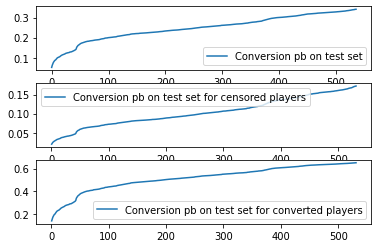

In [225]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1)
ax1.plot(1- pd.DataFrame(pred).mean(), label='Conversion pb on test set')
ax1.legend(loc="lower right")

ax2.plot(1-predictions[predictions.CONVERTED_VALHALLA==0].loc[:,1:531].mean(), label='Conversion pb on test set for censored players')
ax2.legend(loc="upper left")

ax3.plot(1-predictions[predictions.CONVERTED_VALHALLA==1].loc[:,1:531].mean(), label='Conversion pb on test set for converted players')
ax3.legend(loc="lower right")

In [214]:
def pb_at_conv(x):
    try :
        return x[int(x.TEND)]
    except :
        return np.nan

def pb_at_conv_moins1M(x):
    try :
        return x[int(x.TEND) - 30]
    except :
        return np.nan
    
def pb_at_conv_plus1M(x):
    try:
        return x[int(x.TEND) + 30 ]
    except :
        return np.nan

def pb_at_conv_plus10D(x):
    try:
        return x[int(x.TEND) + 10 ]
    except :
        return np.nan
    

def pred_AC_survival(pred_set):
    pred_set['pb_conv']=pred_set.apply(pb_at_conv, axis=1)
    pred_set['pb_conv_moins1M']=pred_set.apply(pb_at_conv_moins1M, axis=1)
    pred_set['pb_conv_plus1M']=pred_set.apply(pb_at_conv_plus1M , axis=1)
    pred_set['pb_conv_plus10D']=pred_set.apply(pb_at_conv_plus10D, axis=1)
    return pred_set

In [215]:
predictions=pred_AC_survival(predictions)

In [108]:
predictions

NameError: name 'predictions' is not defined

In [ ]:

in_features = x_train.shape[1]
out_features = 1
batch_norm = True
output_bias = False
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True
epochs = 512

# to tune
list_num_nodes = [[32, 32], [64, 32]]#, [64, 64], [100, 64], [64, 32, 32], [32, 32, 32]]
list_dropout = [0.1, 0.15, 0.2, 0.25]
list_optimizer = [tt.optim.Adam, tt.optim.AdamW]

list_batch_size = [256, 320]

hyper_results = {}


for num_nodes in list_num_nodes:
    for dropout in list_dropout: 
        for optimizer in list_optimizer:
            
            for batch_size in list_batch_size:
                
                net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                                  dropout, output_bias=output_bias)   
                model_CoxCC = CoxCC(net, optimizer) 

                lrfinder_CoxCC = model_CoxCC.lr_finder(x_train, y_train, batch_size, tolerance=10)

                opt_lrs = [0.05, lrfinder_CoxCC.get_best_lr()/5, lrfinder_CoxCC.get_best_lr()/2, lrfinder_CoxCC.get_best_lr()]
                for lr in opt_lrs :
                    start_time = datetime.now()
                    
                    model_CoxCC.optimizer.set_lr(lr)
                    log = model_CoxCC.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val, val_batch_size=batch_size)
                    bas_cum_haz = model_CoxCC.compute_baseline_hazards().cumsum()
                    surv_test = model_CoxCC.predict_surv_df(x_test)
                    ev = EvalSurv(surv_test, durations_test, events_test, censor_surv='km')
                    time_grid = np.linspace(durations_test.min(), durations_test.max(), 200)

                    #f = interpolate.interp1d(bas_cum_haz.index, bas_cum_haz, fill_value='extrapolate')
                    #xnew = np.arange(1, 801, 1)
                    #ynew = f(xnew)  
                    #base_cum_haz = pd.DataFrame(ynew, index=np.arange(1, 801, 1))
                    #partial_haz = np.exp(model_CoxCC.predict(x_to_predict))
                    #extrapolate_survival = pd.DataFrame(np.exp(- np.dot(base_cum_haz , pd.DataFrame(partial_haz).T)))
                    print(str(num_nodes) + "_"+ str(dropout) + "_" + str(optimizer) + "_"+ str(lr)+ "_" + str(batch_size))
                    hyper_results[str(num_nodes) + "_"+ str(dropout) + "_" + str(optimizer) + "_"+ str(lr)+ "_" + str(batch_size)] = (model_CoxCC.score_in_batches(val),
                                                                                                                                      ev.concordance_td(),
                                                                                                                                      ev.integrated_brier_score(time_grid)
                                                                                                                                    )
                    pickle.dump(model_CoxCC, open( "/home/shared/csouvign/"+str(num_nodes) + "_"+ str(dropout) + "_" + str(optimizer) + "_"+ str(lr)+ "_" + str(batch_size)+".pickle", "wb" ) )
                    end_time = datetime.now()
                    print(end_time)